# Profiling Irony and Stereotype Spreaders on Twitter
### Language Processing 2
##### Caroline Amalie Ørum-Hansen, Maja Mittag & Trine K. M. S. Engelund
_______________

# Best model

### **Import functions and libraries**

In [1]:
# import our custom functions
from read_files import *
from feature_tranformers import *

# import libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

### **Import data**

We import the tweets (X) and the true labels (y), and replace the values in y with dummy values.

0 = not ironic, 1 = ironic.

In [2]:
# import data
X, y = get_data()
y = np.where(y == 'NI', 0, 1) # place with dummy values

print(X.shape, y.shape)

(420, 200) (420,)


### **Split data**

We split data in 80% train and 20% test.

In [3]:
# split dataset in train and test
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train shape: ", X_train.shape, "Test shape: ", x_test.shape)

Train shape:  (336, 200) Test shape:  (84, 200)


### **Features**

**Author level features**

In [4]:
# FeatureUnion of features at author level
author_features = [
  ('tfidf', TfidfVectorizer(analyzer='word', # char n-grams
                            ngram_range=(1,3), # use uni-, bi and trigrams
                            max_df = 0.90, # ignore terms that appear in more than 90% of the documents
                            min_df=0.01,)), # ignore terms that appear in less than 1% of the documents
  ('TTR', TTR()), # type-token ratio / lexical diversity
  ('average_word', avg_word()), # average word length
  ('average_char', avg_char()), # average char length
  ('spongebob', spongebob()) # Mocking Spongebob
]

author_features_combined = FeatureUnion(transformer_list=author_features, n_jobs=-1)
author_features_combined

FeatureUnion(n_jobs=-1,
             transformer_list=[('tfidf',
                                TfidfVectorizer(max_df=0.9, min_df=0.01,
                                                ngram_range=(1, 3))),
                               ('TTR', TTR()), ('average_word', avg_word()),
                               ('average_char', avg_char()),
                               ('spongebob', spongebob())])

In [5]:
# Pipeline for features at author level
author_pipe = Pipeline([
    ('preprocesser_author', preprocess()), # preprocess the tweets
    ('features', author_features_combined) # compute features
])

**Tweet level features**

In [6]:
# FeatureUnion of features at tweet level
tweet_features = [
  ('emoji_sentiment_diff', emoji_sentiment_diff()),
  ('sentiment_incongruity', sentiment_incongruity())
]

tweet_features_combined = FeatureUnion(transformer_list=tweet_features, n_jobs=-1)
tweet_features_combined

FeatureUnion(n_jobs=-1,
             transformer_list=[('emoji_sentiment_diff', emoji_sentiment_diff()),
                               ('sentiment_incongruity',
                                sentiment_incongruity())])

In [7]:
# Pipeline for features at tweet level
tweet_pipe = Pipeline([
    ('preprocesser_tweet', empty2dot()), # preprocess the tweets
    ('features', tweet_features_combined), # compute features
])

**Combine all features**

In [8]:
# combine all features
all_features = FeatureUnion(
    [
    ('authors_features', author_pipe), # features at author level
    ('tweet_features', tweet_pipe), # features at tweet level
    ('stylometric_counts', stylometric_counts()) # stylistic counts (also at author level)
    ],
    n_jobs=-1)
all_features

FeatureUnion(n_jobs=-1,
             transformer_list=[('authors_features',
                                Pipeline(steps=[('preprocesser_author',
                                                 preprocess()),
                                                ('features',
                                                 FeatureUnion(n_jobs=-1,
                                                              transformer_list=[('tfidf',
                                                                                 TfidfVectorizer(max_df=0.9,
                                                                                                 min_df=0.01,
                                                                                                 ngram_range=(1,
                                                                                                              3))),
                                                                                ('TTR',
                            

### **Pipeline**

**Initialize pipeline**

In [9]:
# initiate pipeline 
pipe = Pipeline([
    ('features', all_features), # compute features
    ('scaler', MaxAbsScaler()), # scale features
    ('classifier', RandomForestClassifier(n_estimators=300, n_jobs=-1)), # run classifier
])
pipe

Pipeline(steps=[('features',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('authors_features',
                                                 Pipeline(steps=[('preprocesser_author',
                                                                  preprocess()),
                                                                 ('features',
                                                                  FeatureUnion(n_jobs=-1,
                                                                               transformer_list=[('tfidf',
                                                                                                  TfidfVectorizer(max_df=0.9,
                                                                                                                  min_df=0.01,
                                                                                                                  ngram_range=(1,
                                 

**Fit pipeline**

In [10]:
pipe.fit(X_train, Y_train)

Pipeline(steps=[('features',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('authors_features',
                                                 Pipeline(steps=[('preprocesser_author',
                                                                  preprocess()),
                                                                 ('features',
                                                                  FeatureUnion(n_jobs=-1,
                                                                               transformer_list=[('tfidf',
                                                                                                  TfidfVectorizer(max_df=0.9,
                                                                                                                  min_df=0.01,
                                                                                                                  ngram_range=(1,
                                 

### **Results**

**Accuracy**

In [11]:
print("Train accuracy:", pipe.score(X_train,Y_train))
print("Test accuracy:", pipe.score(x_test,y_test))

Train accuracy: 1.0
Test accuracy: 0.8928571428571429


**Predictions**

In [12]:
# true labels on test set
y_test

array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1])

In [13]:
# predicted labels on test set
y_pred = pipe.predict(x_test)
y_pred


array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1])

**Plot**

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


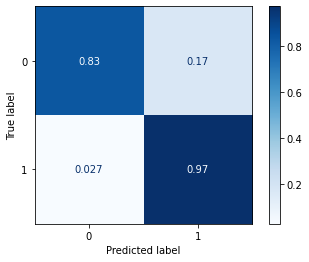

In [14]:
plot_confusion_matrix(pipe, x_test, y_test, cmap='Blues', normalize='true')
plt.show()